<img src="https://drive.google.com/uc?id=1DvKhAzLtk-Hilu7Le73WAOz2EBR5d41G" width="500"/>

---


# **CNNs: convolutional neural networks**


#### **Morning contents/agenda**

1. What are convolutions?

2. How do we use them? (`Torch` layer operations)

3. Visual roadmap of a CNN

4. Implementation of a network similar to LeNet5

5. Training our LeNet5-like network on `MNIST`


#### **Learning outcomes**

1. Have a clear idea of how convolutions work

2. Understand the parameters trained in a CNN

3. CNN architectures and combinations with other types of layers

4. Implementation of  asimple CNN in `PyTorch`

<br>

#### **Afternoon contents/agenda**

1. Dropout and batch normalisation

2. Training with data augmentation

#### **Learning outcomes**

1. Implement dropout and batchnorm layers in `PyTorch`

2. Perform data augmentations and understand its effects


<br/>

---

<br/>

In [ ]:
!pip install pycm livelossplot
%pylab inline

from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torchsummary import summary

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 11.1 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


In [ ]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

Cuda installed! Running on GPU!


# Recap previous concepts and codes:

<center><img src="https://drive.google.com/uc?id=1qhg0BLvyD2CmJ-lbI-BX33LpeiU-a8Va" width="800"/></center>

<center><img src="https://drive.google.com/uc?id=1dDQPNao_VkvrmMHYCg77eRQdpLa7sw2K" width="800"/></center>

<center><img src="https://drive.google.com/uc?id=1ZLTLjFnEnE03KniQR2lyCfpWPbJyHgU9" width="800"/></center>


<center><img src="https://drive.google.com/uc?id=1JwvlolMiU2PysSSbilzIZ7sqrFGZBrux" width="800"/></center>


<center><img src="https://drive.google.com/uc?id=1jmgESg4H1bi1CaNumswAtXs0D7ZH_8UT" width="800"/></center>


<center><img src="https://drive.google.com/uc?id=1f6ZKZnEqjMe7JVLvd0GvAjuQyteZL1qX" width="800"/></center>



---
 <br>
 <br>

So far we have learned how to implement a simple FFN in PyTorch, how to train it, and how to find optimal hyperparameters for it. Today we will apply this concepts to a new architecture: CNNs.

CNNs are widely used mostly, **but not only**, in computer vision problems:

<center><img src="https://drive.google.com/uc?id=1kdQpSH9fLNYyBtZvQ0KXDBqBlr_0OEbb" width="600"/></center>


## 1. What are convolutions?

Convolutions are operations between two functions or discrete representations where the output is the result of multiplying and adding their elements at different relative positions.

An image is perhaps better suited to describe this:

<!---<br>

 <center><img src="https://drive.google.com/uc?id=13olO6eqI89ukoZ7hqZXZL4_NqzalsP6W" width="800"/></center>

<br> --->

<br>

<center><img src="https://drive.google.com/uc?id=16sYFaFyVNQw4NIiIU_OHnJlsvMDrqcPJ" width="800"/></center>

<br>

And there is a bit to unpack here. The first equation describes a convolution operation between $x$ and $W$, which results in $y$. In essence this is what convolutions do. The other two lines are there to highlight how we will be using convolutions in the layers of networks. An example of convolving and applying a ReLU activation from [this blog](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/):

<br>


<center><img src="https://ujwlkarn.files.wordpress.com/2016/08/giphy.gif?w=480&zoom=2" width="600"/></center>

<center><img src="https://ujwlkarn.files.wordpress.com/2016/08/screen-shot-2016-08-07-at-6-18-19-pm.png?w=1496" width="600"/></center>

<br>

...but let's park the activations and biases for now.

Convolutions can be described with only 4 parameters:

- input size
- filter or kernel size
- stride
- padding

<br>

<center><img src="https://drive.google.com/uc?id=1V81dhsD0eD5dvIul8tJmwrDhQcAuUhMG" width="800"/></center>

<br>

A few simple examples to help clarify convolutions with different strides and paddings:

<img src="https://drive.google.com/uc?id=1kYve-IfJv5a25KxKDv4D7Zrf69i9LD7b" width="200"/>
<img src="https://drive.google.com/uc?id=142TRExJSGa4mGn-8M6aLksGkTQSPtcXS" width="200"/>
<img src="https://drive.google.com/uc?id=19N9b64dbLhSRpRvq-DJk184TSfVDeQGm" width="200"/>
<img src="https://drive.google.com/uc?id=1-LAL5YPnwnXiFHZNBFTWC17UFP6dDRzA" width="200"/>

<br>

**Question**: what are the padding and stride values for each one of the above cases?

And now we see that the size of the output depends on all four parameters of the convolution: input size, filter size, stride, and padding.

<br>

A more detailed explanation of convolutions from a more mathematical perspective can be found in this brilliant (as always) [video by 3blue1brown](https://www.youtube.com/watch?v=KuXjwB4LzSA)

<br/>

---

<br/>

## 2. How do we use them? (Torch layer operations)

Now that we are familiar with convolution operations, how do we use them in convolutional neural networks?

The procedure is similar to what we have already seen in feed-forward networks, but the exchange of information between layers is now done using convolutions instead of linear mapppings (where all outputs of one layer are used to compute the inputs of the next).

So, instead of this kind of architecture (FFN):

<br>

<center><img src="https://thumbs.gfycat.com/AdorableJoyfulLemming-max-1mb.gif" alt="network" width="500"/></center>

<br>

we now use CNNs, and we do not have to alter the original dimensions of the data (no need to perform the flatten operation in the first step of the animation above):

<br>

<center><img src="https://drive.google.com/uc?id=1_9GLVFv8GkQbKsCHt3qZQWrQyPMezUNC" width="800"/></center>

<br>

This is one of the main advantages of using CNNs, it preserves some information about the spatial distribution of the data. The image above corresponds to the architecture of [LeNet-5](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf), introduced by Yann LeCun, Leon Bottou, Yoshua Bengio, and Patrick Haffner in **1998**

The number of trainable parameters in FFNs is uniquely defined by the number of neurons (or units) in each layer, plus the bias term if we use it. These trainable parameters are the weights (and biases) that connect neurons from one layer to neurons to the next layer.

The number of trainable parameters in a CNN depends on the size of the filters at each layer and the number of channels (or feature maps) in each layer. The trainable parameters in the convolutional layers of a CNN are the coefficients of the filters (commonly referred to as convolutional kernels), denoted by $W_i$ in the figure above.



To better illustrate how the input and output channels are defined in convolutional layers, consider:

<center></center>

<br>

<p align = "center"><img src="https://drive.google.com/uc?id=1sMStdtSRWhuPvSuAMGEwJg6huRl22U5f" width="800"/></p><p align = "center">
<i>3-channel input (RGB image) and 2-channel output example</i>
</p>

#### **Exercise**:
**If I have a layer with 10 features, each of size 50x50, and I apply 25 filters of size 3x3x10 and stride 1, no padding. What is the size and number channels of the next layer?**

#### **Answer**:

**25 channels, each of size 48x48**

<br>

#### **Exercise**:
**Given the network below, how many trainable parameters do we have?**

<br>

<center><img src="https://drive.google.com/uc?id=1-IqVfFHi_foHyqpVHMqsdPzrKZcy_3jB" width="800"/></center>

<br>

#### **Answer**:

In [ ]:
print('The network has', 10*28+20*251+40*501+1961, 'parameters')

The network has 27301 parameters


In the LeNet-5 representation we also have **subsampling** and **full-connection** layers. We already know what a full-connection layer is, as they are the same kind of layers we used in FFNs.

Subsampling (and upsampling, as we will see later) are operations that reduce the dimensionality of the data. The two most common ones are average pooling and max pooling:

<br>

<center><img src="https://drive.google.com/uc?id=1ksmCBAjlh7nSrxBORzUq4LBhLXkCG372" width="600"/></center>

<br>

## 3. Visual roadmap of a CNN

Let's play a bit with the tools provided by PyTorch to implement convolutional layers with a simple one-layer operation example. We will also implement some of the concepts discussed yesterday like dropout and batch normalisation.

PyTorch classes we will use:

- [`nn.Conv2d`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html): Convolutional layers are parameterized by their kernel-weights and biases and are often used to reduce the spatial dimensionality.

- [`nn.ConvTranspose2d`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html): Transposed convolutions (not deconvolutions!); similar to convolutions, but normally used to upsample (increase the spatial dimensionality). [Interesting blog discussing problems with tranposed convolutions](https://distill.pub/2016/deconv-checkerboard/) and [intuitive animations of transposed convolutions](https://github.com/vdumoulin/conv_arithmetic)

- [`nn.UpsamplingBilinear2d`](https://pytorch.org/docs/stable/generated/torch.nn.UpsamplingBilinear2d.html) for upsampling (also check nearest neighbor upsampling, `nn.Upsample`)

- [`nn.MaxPool2d`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html): Pooling layers summarize spatial information (also check  `nn.AvgPool2d`)

- [`nn.Dropout2d`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout2d.html): Also exists in more dimensions: Can be use to regularise training of deep networks

- Batch normalisation: Shift and center the distribution of the weights to a centered Gaussian distribution by keeping a running average of mini-batch properties. Introduced in [this paper](https://arxiv.org/abs/1502.03167). Originally, it was thought that doing batch normalisation would reduce the internal covariate shift and accelerate training, but a [later paper](https://arxiv.org/abs/1805.11604) questioned if that was the real reason why it was working so well. It seems to help learning in very deep convolutional neural networks, but it is not really well understood why this is the case.

\[**NOTE**: The pytorch documentation is extremely well organised and I highly recommend you use it to your own advantage.\]

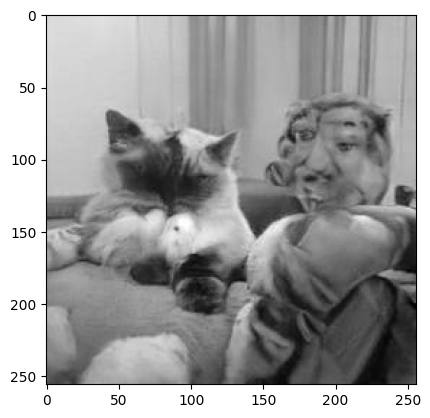

In [ ]:
# get an image of a cat

from PIL import Image  # PIL is hte Python Imaging Library
import requests        # library that provides an easy way to make http requests
from io import BytesIO # let's us read raw bites as a file

# url = "https://cataas.com/cat" #--> cat as a service is down :-(  use this instead:
# get a cat from here:
#https://thesecatsdonotexist.com/
url = "https://d2ph5fj80uercy.cloudfront.net/05/cat4983.jpg" # cat as a service!

response = requests.get(url)   # requests a cat
img = np.array(Image.open(BytesIO(response.content)).convert('L')).astype(float) # BytesIO tells python to read it as a file (and .content extracts only the image bytes)
plt.imshow(img, cmap="gray");   # matplotlib likes numpy arrays

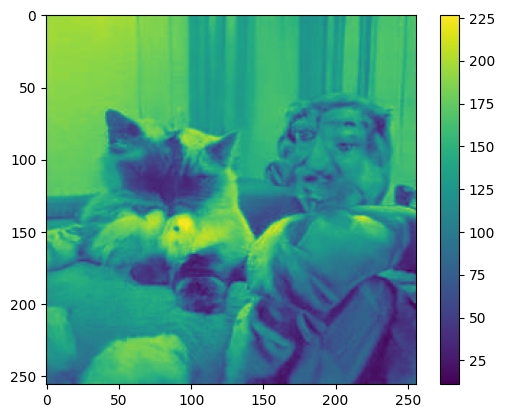

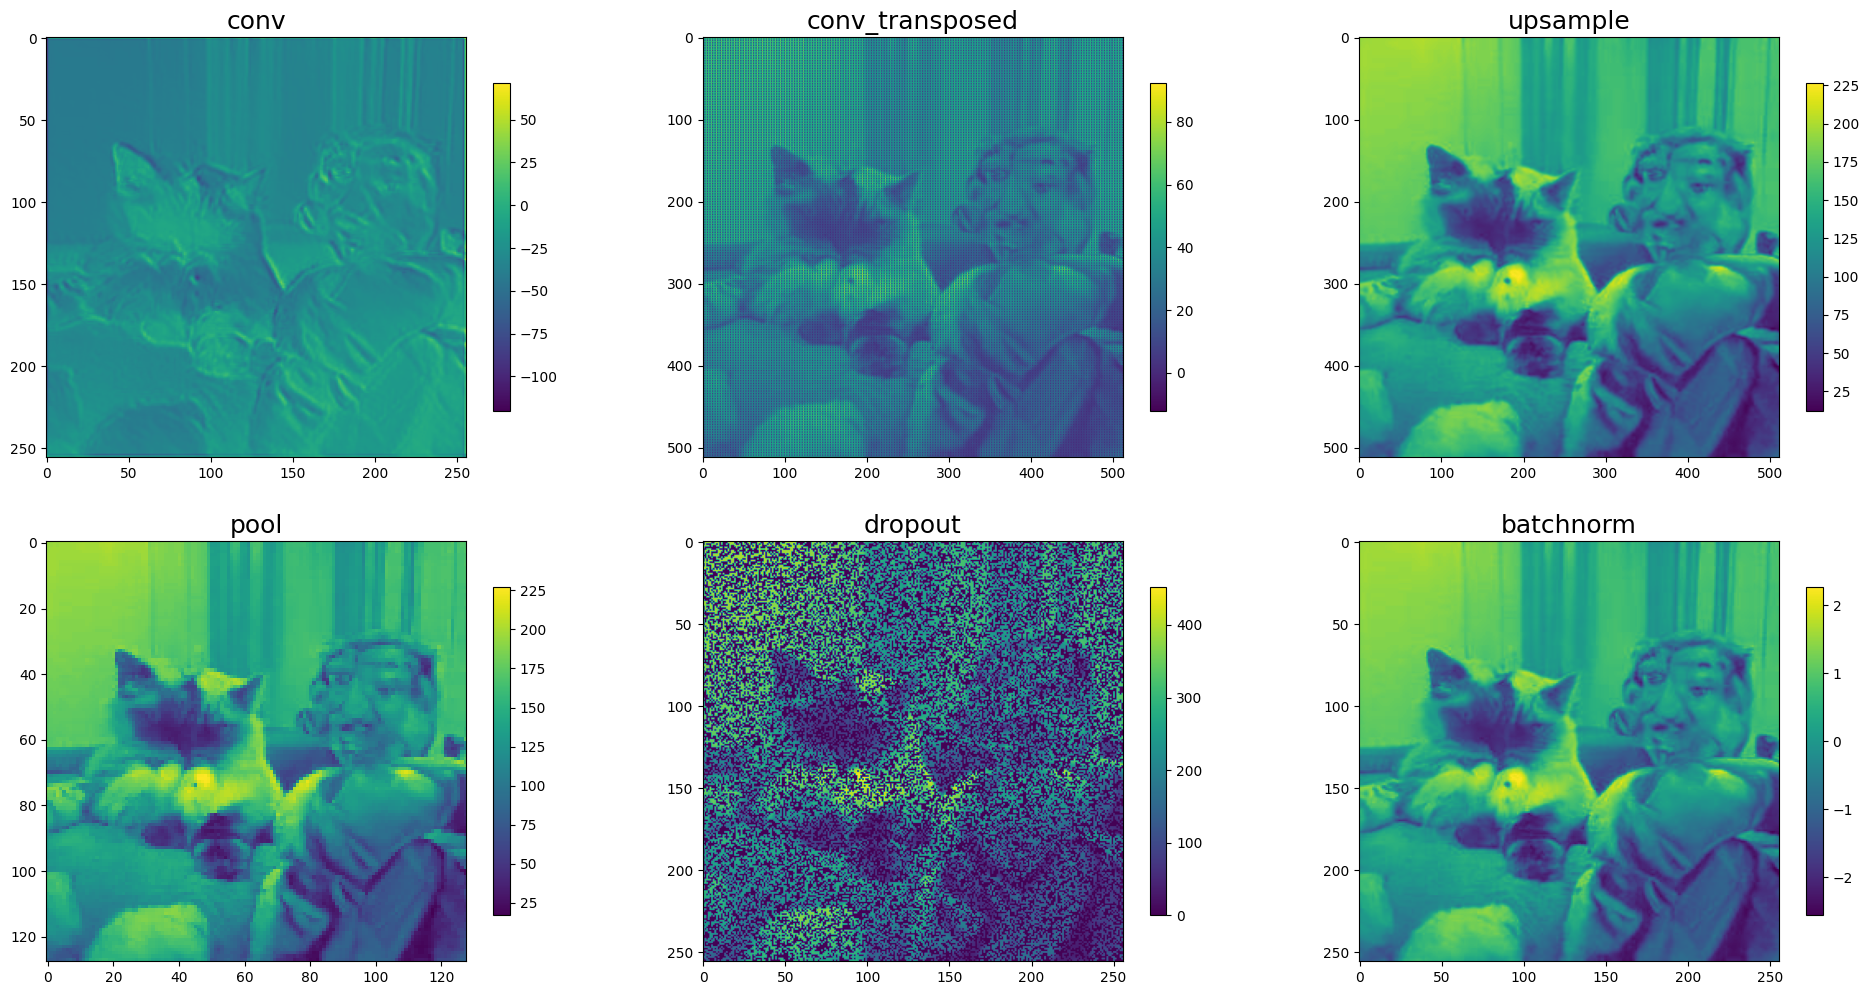

In [ ]:
# apply some layer operations to the cat image:

# first convert the cat image to a torch tensor:
x = torch.from_numpy(img).view(1, 1, img.shape[0], img.shape[1]).float()   # load the cat image as a tensor


convolution = nn.Conv2d(1, 1, kernel_size=5, padding=2, stride=1)
transposed_convolution = nn.ConvTranspose2d(1, 1, kernel_size=2, stride=2)
upsampling = nn.UpsamplingBilinear2d(scale_factor=2)
pool = nn.MaxPool2d(kernel_size=2, stride=2)
dropout = nn.Dropout(0.5)
#dropout = nn.Dropout2d(0.5) (dropout 2D is designed to drop feature maps or channels in a network!)
batchnorm = nn.BatchNorm2d(1) ##1 corresponds to the number of output channels in the convolutional layer

plt.imshow(img)
plt.colorbar()

fig, axarr = plt.subplots(2, 3, figsize=(24, 12))
for ax, op, name in zip(axarr.flatten(), [convolution, transposed_convolution, upsampling, pool, dropout, batchnorm], ["conv", "conv_transposed", "upsample", "pool", "dropout", "batchnorm"]):
  filtered = op(x)
  im = ax.imshow(filtered[0, 0].detach().numpy())
  ax.set_title(name, fontsize=18)
  fig.colorbar(im, ax=ax, fraction=0.03)
plt.show()


Finally, we can put it all together and see how a **trained** CNN operates:

In [ ]:
%%html
<iframe src="https://poloclub.github.io/cnn-explainer/" width="1200" height="700"></iframe>

<br>

---

<br>

## 4. Implementation of a network similar to LeNet5

We will now use the layer classes we just saw to implement a version of Yann LeCun's LeNet-5 introduced in [this paper](http://vision.stanford.edu/cs598_spring07/papers/Lecun98.pdf):

<br>

<center><img src="https://drive.google.com/uc?id=1_9GLVFv8GkQbKsCHt3qZQWrQyPMezUNC" width="800"/></center>

<br>

- Here the network is shown to have input's of size 32x32, so we will tell our first convolutional layer to add some padding to our 28x28 FasionMNIST images.  
- All convolutional layers with trainable parameters should have:
  - kernel-size=5
  - stride 1
  - padding 2
- All MaxPool layers use a kernel size 2 and a stride value of 2.
- Use ReLUs for all activations.
- Use bias terms (default in most PyTorch layers).



Implement our version of LeNet-5 according to the instructions above:

In [ ]:
class LeNet5(nn.Module):
  def __init__(self):
    super(LeNet5, self).__init__()
    self.c1 = nn.Conv2d(1, 6, kernel_size=5, stride=1, padding=2) # define a 2D convolutional layer
    self.s2 = nn.MaxPool2d(kernel_size=2, stride=2)               # define a maxpool layer
    self.c3 = nn.Conv2d(6, 16, kernel_size=5, stride=1)           # new 2D convolutional layer
    self.s4 = nn.MaxPool2d(kernel_size=2, stride=2)               # another maxpool layer
    self.c5 = nn.Linear(16*5*5, 120)                              # first linear layer
    self.f6 = nn.Linear(120, 84)                                  # second linear layer
    self.output = nn.Linear(84, 10)                               # final output layer
    self.act = nn.ReLU()                                          # activation function

  def forward(self, x):
    x = self.act(self.c1(x))                                      # activate pass through the first layer
    x = self.act(self.s2(x))                                      # activate pass through the second layer
    x = self.act(self.c3(x))                                      # activate pass through the third layer
    x = self.act(self.s4(x))                                      # activate pass through the fourth layer
    x = x.view(-1, x.size(1)*x.size(2)*x.size(3))                 # flatten (return a "flattened" view of the 3d tensor as inputs for the fully connected layer)
    x = self.act(self.c5(x))                                      # activate pass through fifth layer
    x = self.act(self.f6(x))                                      # activate pass through last layer
    return self.output(x)                                         # return output

x = torch.randn((1, 1, 28, 28))
model = LeNet5()
y = model(x)
print(y)
print(model)

tensor([[ 0.1027,  0.0524,  0.0900,  0.0824,  0.0073,  0.0377,  0.0078, -0.0325,
          0.0122,  0.0067]], grad_fn=<AddmmBackward0>)
LeNet5(
  (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (s2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (s4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (c5): Linear(in_features=400, out_features=120, bias=True)
  (f6): Linear(in_features=120, out_features=84, bias=True)
  (output): Linear(in_features=84, out_features=10, bias=True)
  (act): ReLU()
)


Get the MNIST dataset:

In [ ]:
mnist_train = MNIST("./", download=True, train=True)
mnist_test = MNIST("./", download=True, train=False)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Instantiate and create a ```StratifiedShuffleSplit``` using sklearn.
1. Create a ```sklearn.model_selection.StratifiedShuffleSplit``` object with 1-split and a test-size of 10%.
2. Get the training and validation indices from the shuffel-split

In [ ]:
# split the data
shuffler = StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42).split(mnist_train.train_data, mnist_train.train_labels)
indices = [(train_idx, validation_idx) for train_idx, validation_idx in shuffler][0]

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


Standardise and split the MNIST dataset:

The original MNIST data is given in gray-scale values between 0 and 255.
You will need to write a normalisation method that takes in a ```torch.Tensor``` and performs normalisation.
The mean of MNIST is 0.1307 and it's standard deviation is 0.3081 (after division by 255).

In [ ]:
def apply_standardization(X): # define an standardisation function
  X /= 255.
  X -= 0.1307
  X /= 0.3081
  return X

In [ ]:
# standardise the data
X_train, y_train = apply_standardization(mnist_train.train_data[indices[0]].float()), mnist_train.train_labels[indices[0]]
X_val, y_val = apply_standardization(mnist_train.train_data[indices[1]].float()), mnist_train.train_labels[indices[1]]
X_test, y_test =  apply_standardization(mnist_test.test_data.float()), mnist_test.test_labels

/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.8/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Instantiate a ```torch.utils.data.TensorDataset``` for training, validation and test data:

Remember that we use TensorDataset to be able to operate on the dataset without having to load it all in memory.

And remember that torch likes all categorical data to be in a ```.long()``` format.

In [ ]:
# create the TensorDatasets containing mnist_train, mnist_validate, and mnist_test
mnist_train = TensorDataset(X_train, y_train.long())
mnist_validate = TensorDataset(X_val, y_val.long())
mnist_test = TensorDataset(X_test, y_test.long())

Let's visualise an example of the images and check whether the data is normalised properly (compute .mean() and .std() on the training set.)

tensor(0.0001) tensor(1.0003)


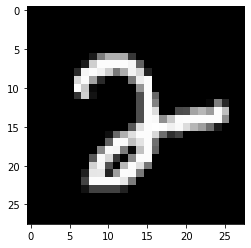

In [ ]:
plt.imshow(X_train[0], cmap = 'gray')
print(X_train.mean(), X_train.std())

### Provided Train, Validation and Evaluate Functions

There is an error in these functions. Can you spot it?

In [ ]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    train_loss, train_accuracy = 0, 0
    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        a2 = model(X.view(-1, 1, 28, 28))
        #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
        loss = criterion(a2, y)
        loss.backward()
        train_loss += loss*X.size(0)
        y_pred = F.log_softmax(a2, dim=1).max(1)[1]
        train_accuracy += accuracy_score(y.cpu().numpy(), y_pred.detach().cpu().numpy())*X.size(0)
        optimizer.step()

    return train_loss/len(data_loader.dataset), train_accuracy/len(data_loader.dataset)

def validate(model, criterion, data_loader):
    model.eval()
    validation_loss, validation_accuracy = 0., 0.
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            loss = criterion(a2, y)
            validation_loss += loss*X.size(0)
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            validation_accuracy += accuracy_score(y.cpu().numpy(), y_pred.cpu().numpy())*X.size(0)

    return validation_loss/len(data_loader.dataset), validation_accuracy/len(data_loader.dataset)

def evaluate(model, data_loader):
    model.eval()
    ys, y_preds = [], []
    for X, y in data_loader:
        with torch.no_grad():
            X, y = X.to(device), y.to(device)
            a2 = model(X.view(-1, 1, 28, 28))
            #a2 = model(X.view(-1, 28*28)) #What does this have to look like for our conv-net? Make the changes!
            y_pred = F.log_softmax(a2, dim=1).max(1)[1]
            ys.append(y.cpu().numpy())
            y_preds.append(y_pred.cpu().numpy())

    return np.concatenate(y_preds, 0),  np.concatenate(ys, 0)

### Set the hyperparameters of your model

- Seed: 42
- learning rate: 1e-2
- Optimizer: SGD
- momentum: 0.9
- Number of Epochs: 30
- Batchsize: 64
- Test Batch Size (no effect on training apart from time): 1000
- Shuffle the training set every epoch: Yes

In [ ]:
seed = 42
lr = 1e-2
momentum = 0.5
batch_size = 64
test_batch_size = 1000
n_epochs = 30

In [ ]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)

In [ ]:
next(iter(train_loader))
print(type(train_loader))

<class 'torch.utils.data.dataloader.DataLoader'>


### Perform the training of the network and validation

- Instantiate our model, optimizer and loss function
- Set the random number generator seed using ```set_seed``` to make everything reproducible.
- Use a sensible loss (criterion) for the multi-class classification problem.

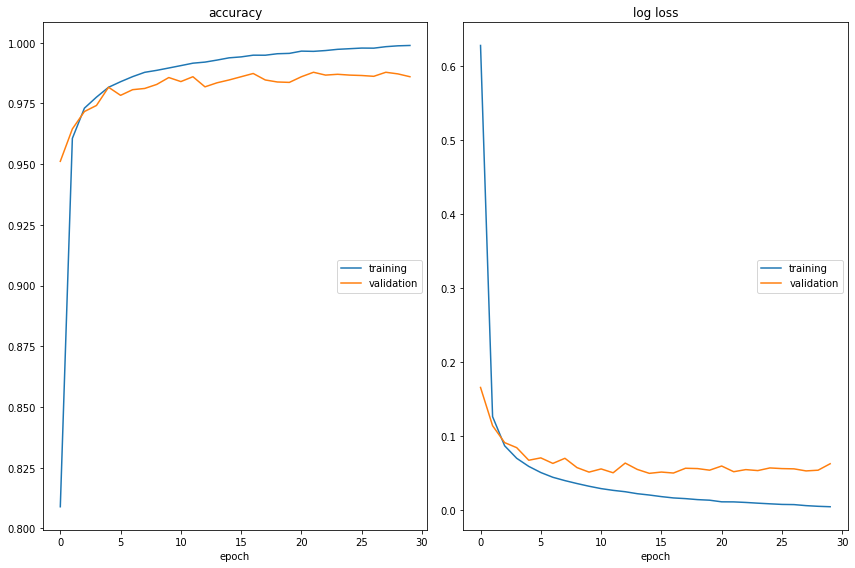

accuracy
	training         	 (min:    0.809, max:    0.999, cur:    0.999)
	validation       	 (min:    0.951, max:    0.988, cur:    0.986)
log loss
	training         	 (min:    0.004, max:    0.628, cur:    0.004)
	validation       	 (min:    0.049, max:    0.166, cur:    0.062)


In [ ]:
def train_model(momentum):
  set_seed(seed)
  model = LeNet5().to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
  criterion = nn.CrossEntropyLoss()

  train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=0)
  validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
  test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

  liveloss = PlotLosses()
  for epoch in range(30):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss.item()
      logs['' + 'accuracy'] = train_accuracy.item()

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss.item()
      logs['val_' + 'accuracy'] = validation_accuracy.item()

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model(0.5)

<br>

Results obtained with the feed-forward network from previous sessions:

<img src="https://drive.google.com/uc?id=1dcJ-7XgGceI7XtZ_wWhHhsUAv4G5vk4Z" width="600"/>

<br>

### Use the evaluation function defined above to make predictions.

This method performs the same as validate but doesn't report losses, but simply returns all predictions on a given dataset (training, validation, test-set)

In [ ]:
validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0) # create a validation_loader
y_pred, y_gt = evaluate(model, validation_loader) # generate predictions and ground truths by evaluating the model

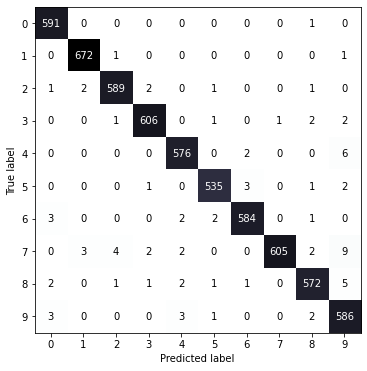

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay.from_predictions(y_gt, y_pred, ax=ax, colorbar=False, cmap='bone_r')
plt.show()

Fully connected network confusion matrix was:

<img src="https://drive.google.com/uc?id=1kzR5_QdAb8Me_lYBThhrE7MJIWfw5ZGg" width="370"/>


## Run a grid-search

We will do a very simple hyperparameter grid-search by testing the optimal value of momemntum for this task.

For that, we will define a new training function:

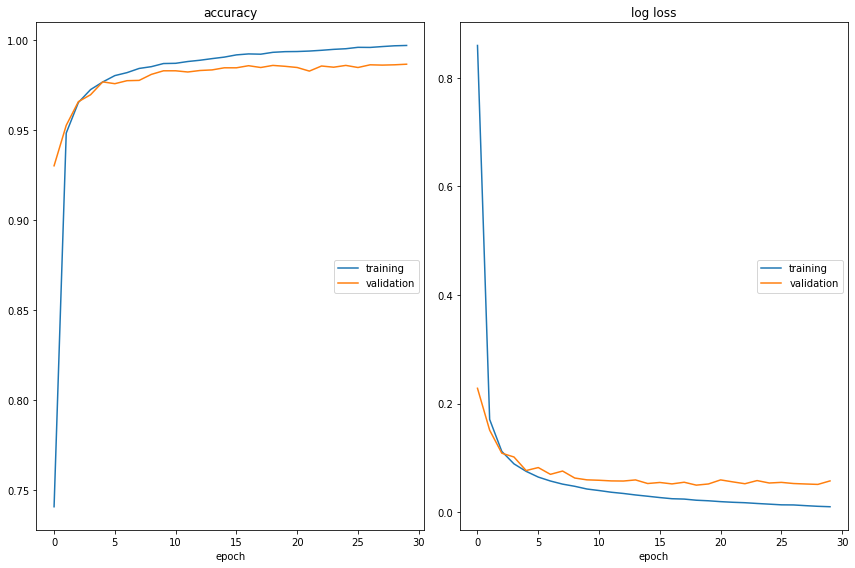

accuracy
	training         	 (min:    0.741, max:    0.997, cur:    0.997)
	validation       	 (min:    0.930, max:    0.987, cur:    0.987)
log loss
	training         	 (min:    0.010, max:    0.860, cur:    0.010)
	validation       	 (min:    0.050, max:    0.228, cur:    0.057)


In [ ]:
model_m02 = train_model(0.2)

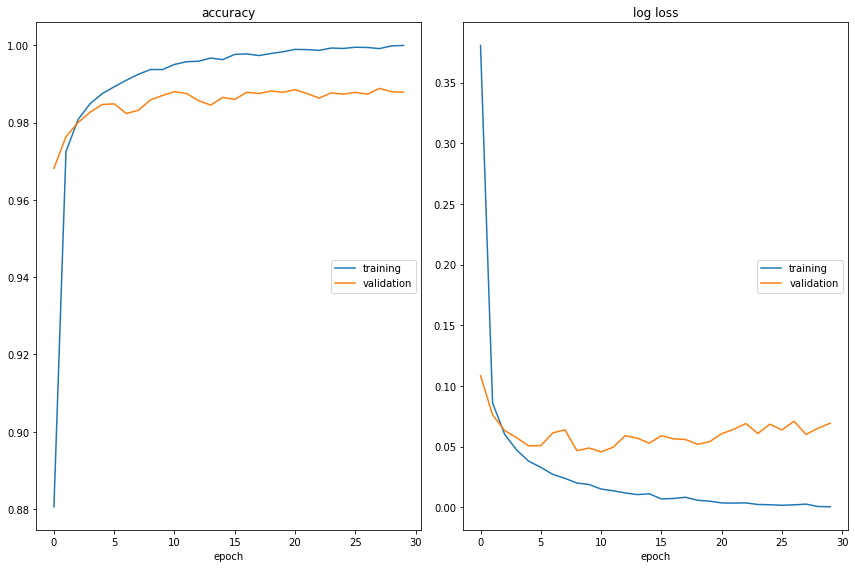

accuracy
	training         	 (min:    0.881, max:    1.000, cur:    1.000)
	validation       	 (min:    0.968, max:    0.989, cur:    0.988)
log loss
	training         	 (min:    0.001, max:    0.381, cur:    0.001)
	validation       	 (min:    0.046, max:    0.109, cur:    0.069)


In [ ]:
model_m08 = train_model(0.8)

In [ ]:
# set the best momentum value we have found:
momentum = 0.5

### Train the model on the full dataset and evaluate on the test set

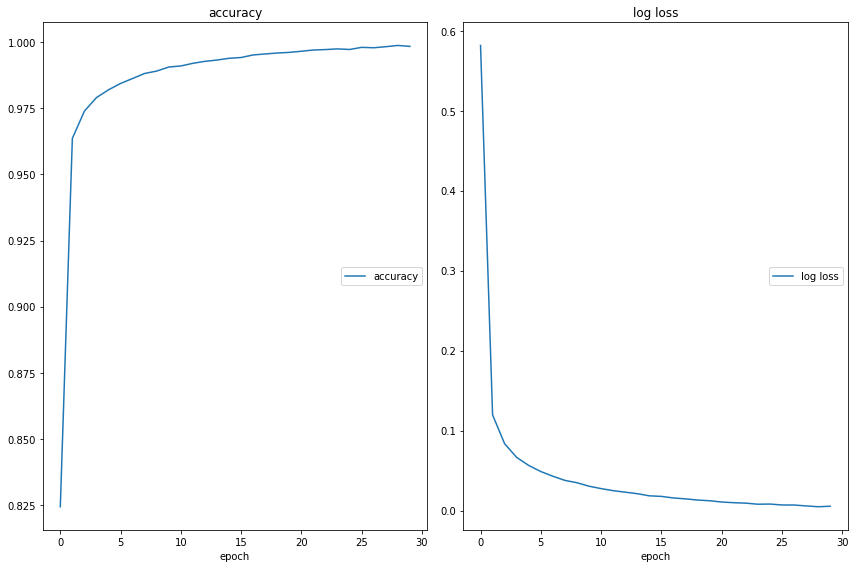

accuracy
	accuracy         	 (min:    0.824, max:    0.999, cur:    0.998)
log loss
	log loss         	 (min:    0.005, max:    0.582, cur:    0.005)
Avg. Test Loss: 0.037  Avg. Test Accuracy: 0.990



In [ ]:
mnist_train = MNIST("./", download=True, train=True) # reload MNIST (why do we do this?)

X_train, y_train = apply_standardization(mnist_train.train_data.float()), mnist_train.train_labels
mnist_train = TensorDataset(X_train, y_train)
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=4) # turn on multi-process data loading with the specified number of loader worker processes.

set_seed(seed)
model = LeNet5().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)
criterion = nn.CrossEntropyLoss()

liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

    logs['' + 'log loss'] = train_loss.item()
    logs['' + 'accuracy'] = train_accuracy.item()
    liveloss.update(logs)
    liveloss.draw()
    logs['val_' + 'log loss'] = 0.
    logs['val_' + 'accuracy'] = 0.


validation_loader = DataLoader(mnist_validate, batch_size=test_batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(mnist_test, batch_size=test_batch_size, shuffle=False, num_workers=0)

test_loss, test_accuracy = validate(model, criterion, test_loader)
print("Avg. Test Loss: %1.3f" % test_loss.item(), " Avg. Test Accuracy: %1.3f" % test_accuracy.item())
print("")


#### [**Note on num_workers**]

[`num_workers`](https://pytorch.org/docs/stable/data.html#multi-process-data-loading) have (or maybe had) a famous bug where setting it to any number bigger than 0 would result in memory leaks. The reason for that is related to how the processes are forked using `copy-on-write`. In principle, copy-on-write should not happen as we are only accessing data, but in reality it does happen because we are modifying something called reference count which results in actual writes on the data we are reading, and that activates the `write` in the `copy-on-write`. The result of that is that as we are iterating over the dataloader, we start creating more and more memory copies of our data which eventually can throw an 'out memory error'. More on this here: https://pytorch-dev-podcast.simplecast.com/episodes/dataloader-with-multiple-workers-leaks-memory.